<a href="https://colab.research.google.com/github/SSInimgba/Computer_Vision/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import the necessary libraries

from collections import Counter
from pathlib import Path


from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import os
import natsort
from natsort import natsorted
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as dset
from torchvision.models import resnet18
from torchvision import transforms as T
from torchvision.utils import make_grid
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [0]:
#Transform Image
transformations = T.Compose([
                            T.Resize(224),
                            T.CenterCrop(224),
                            T.ToTensor(),
                            #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [0]:
 data = dset.ImageFolder('/content/images', transform = transformations)
 loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
#Image Labels
class_names = data.classes
class_names

['fried_rice',
 'jollof_rice',
 'ofada_rice',
 'village_rice',
 'white_rice_and_stew']

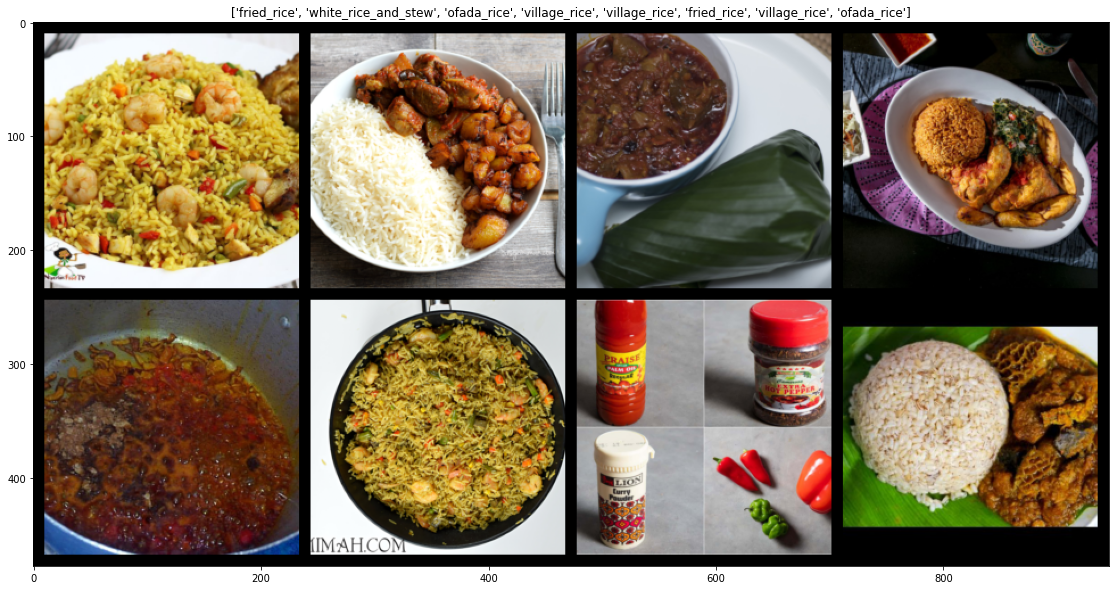

In [0]:
#Visualize the images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
   #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (20,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of the data
viz_batch = torch.utils.data.DataLoader(data, batch_size=8, num_workers=0, shuffle=True)
inputs, classes = next(iter(viz_batch))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow = 4, padding = 10)
imshow(out, title=[class_names[x] for x in classes])

We can see some problems with the image dataset.
1. There are images that are not rice dishes.
2. There are images in the wrong classes, eg jollof rice in the white rice and stew class. This is why we need to carry out an unsupervised clustering to clean the dataset

Viewing the dataset we can identify 2 types of noise
1. Non food items 
2. Food items in the wrong classes

In order to improve the quality of the dataset, the dataset had to be filtered to remove non-food items and the food items in the wrong class have to be corrected. 

## Filtering out Non food items

We adapted https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5537777/ 

In [0]:
#methods for displaying the datasets

def show_cluster(cluster, labels, dataset, limit=32):
  images = []
  labels = np.array(labels)
  indices = np.where(labels == cluster)[0]


  if not indices.size:
    print(f'cluster:{cluster} is empty.')
    return None


  for i in indices[:limit]:
    image, _ = dataset[1]
    images.append(image)


  gridded = make_grid(images)
  plt.figure(figsize = (15,10))
  plt.title(f'cluster: {cluster}')
  plt.imshow(gridded.permute(1,2,0))
  plt.axis('off')




def show_neighbors(neighbors, dataset):
  images = []
  for n in neighbors:
    images.append(dataset[n][0])



  gridded = make_grid(images)
  plt.figure(figsise = (15,10))
  plt.title(f'image and nearest neighbors')
  plt.imshow(gridded.permute(1,2,0))


def extract_features(model, dataset, batch_size=32):
  """
  Gets the output of a model given a dataset
  """
  loader = DataLoader(dataset, batch_size=batch_size)
  features = []

  for image, _ in tqdm(loader, desc = 'extracing features'):
    output = model(Variable(image).cuda())
    features.append(output.data.cpu())
  return torch.cat(features).numpy()

In [0]:
#Clustering
pca_dim = 2
kmeans_cluster = 4

# convnet
batch_size = 64
num_classes = 4 #(0-4:5)
num_epochs = 10

In [0]:
#Models
#load resnet and alter last layer
model = resnet18()
model.fc = nn.Linear(512, num_classes)
model.cuda();

pca = IncrementalPCA(n_components=pca_dim, batch_size=512, whiten = True)
kmeans = MiniBatchKMeans(n_clusters= kmeans_cluster, batch_size = 512, init_size = 3*kmeans_cluster)
optimizer = Adam(model.parameters())

In [0]:
#Clustering Loop
def cluster(pca, kmeans, model, data, batch_size, return_features = False):
  features = extract_features(model, data, batch_size)
  reduced = pca.fit_transform(features)
  psuedo_labels = list(kmeans.fit_predict(reduced))

  if return_features:
    return psuedo_labels, features
  return psuedo_labels


In [0]:
#Training Loop
def train_epoch(model, optimizer, train_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    total_loss = 0
    pbar = tqdm(train_loader)

    for batch, (images, labels) in enumerate(pbar):
        optimizer.zero_grad()
        images = Variable(images).cuda()
        labels = Variable(labels).cuda().long()
        out = model(images)
        loss = F.cross_entropy(out, labels)
        total_loss += loss.data[0]
        pbar.set_description(f'training - loss: {total_loss / (batch + 1)}')
        loss.backward()
        optimizer.step()


In [0]:
pseudo_labels, features = cluster(pca, kmeans, model, data, batch_size, return_features=True)

extracing features:  60%|██████    | 18/30 [00:33<00:19,  1.65s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
extracing features: 100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


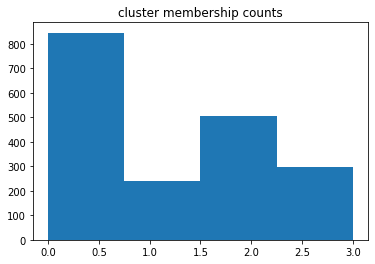

In [0]:
plt.hist(pseudo_labels, bins=kmeans_cluster)
plt.title('cluster membership counts');

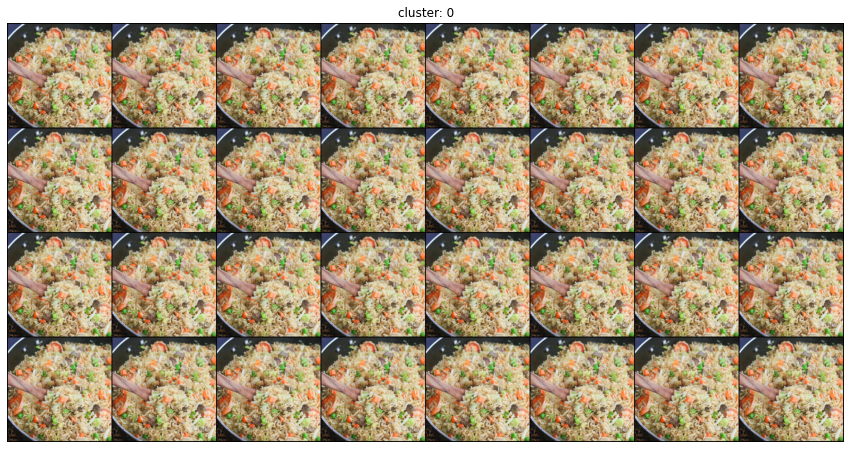

In [0]:
counts = Counter(pseudo_labels)
show_cluster(counts.most_common()[0][0], pseudo_labels, data)


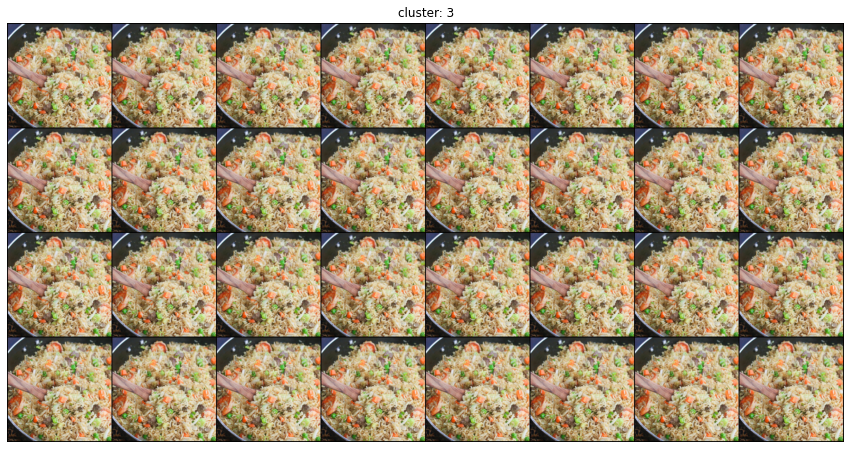

In [0]:
show_cluster(counts.most_common()[2][0], pseudo_labels, data)



Dataset Composition

1.  Fried rice : 254
2.  Jollof rice : 371
3. Ofada rice : 180
4. village rice : 603
5. white rice and stew : 488






















cv_img = []
for img in glob.glob("/content/images/ofada_rice/*.jpg"):
  cv_img.append(img)





class FoodDataSet(Dataset):
  def __init__(self, main_dir, transform):
    self.main_dir = main_dir
    self.transform = transform
    all_imgs = os.listdir(main_dir)
    self.total_imgs = natsort.natsorted(all_imgs)



  def __len__(self):
      return len(self.total_imgs)

  def __getitem__(self, idx):
    img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
    image = Image.open(img_loc).convert("RGB")
    tensor_image = self.transform(image)
    return tensor_image





img_folder_path = 'images'
batch_size = 4
my_dataset = FoodDataSet('/content/images/ofada_rice/', transform=T)
train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=False)


for idx, img in enumerate(train_loader):
  print(idx)


**Image (numpy array) and Class represented as int**
inputs, classes = next(iter(train_loader))


subset_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # select your indices here as a list
subset = torch.utils.data.Subset(data, subset_indices)





In [0]:
7.28 + 2.97 +2.97+2.18+0.10+0.25+7.47+5.96+0.70+9.96+3.98+(1.94 *3)+10.98+7.98+7+6.50+16.48+10.48

109.06000000000002

In [0]:
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    #Transform the Image to fit the specifications sued in training VGG16
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    ##return out # predicted class index
    
    
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
        
    img = Image.open(img_path)
    img_t = transform(img).cuda()
    batch_t = torch.unsqueeze(img_t, 0)
    model = VGG16.eval()
    out = model(batch_t) #gives us a score for all the lables
    
    #read the text file with 1000 labels and store in classes
    with open('imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]
        
    _, index = torch.max(out, 1) #find the index with the max score
    
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100 #get the percentage score
    
    return print(classes[index[0]], percentage[index[0]].item())






def dog_detector(img_path):
    ## TODO: Complete the function.
    
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
        
    img = Image.open(img_path)
    img_t = transform(img).cuda()
    batch_t = torch.unsqueeze(img_t, 0)
    model = VGG16.eval()
    out = model(batch_t) #gives us a score for all the lables
    
    #read the text file with 1000 labels and store in classes
    with open('imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]
        
    _, index = torch.max(out, 1) #find the index with the max score
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100 #get the percentage score
    

    dog_index = list(range(151, 269))
    i = index.item()
    
    return bool(i in dog_index)


    def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loa):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            #clear the gradients.
            optimizer_scratch.zero_grad()
            
            #forward pass
            output = model(data)
            
            #Calculate batch loss
            loss = criterion_scratch(output, target)
            
            #backward pass
            loss.backward()
            
            #optimize 
            optimizer_scratch.step()
            
            #update train_loss
            train_loss += loss.item()*data.size(0)            
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
         
        
        
        
        
        ######################    
        # validate the model #
        ######################
        
        model.eval()
        with torch.no_grad():
        
            for batch_idx, (data, target) in enumerate(val_loader):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                #forward
                output = model(data)
                
                # update the average validation loss
                loss = criterion_scratch(output,target)
                valid_loss += loss.item()*data.size(0)
                
                
            # calculate average losses
            train_loss = train_loss/len(train_data)
            valid_loss = valid_loss/len(val_data)


            # print training/validation statistics 
            print(f'Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}')

        ## TODO: save the model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss))
                torch.save(model.state_dict(), 'model_scratch.pt')
                valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
    

SyntaxError: ignored

In [0]:
+